In [82]:
import numpy as np
from qiskit import QuantumCircuit, Aer, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector

#### Lookup tables

In [69]:
TwoBitLookup = [[[0 for j in range(24)] for i in range(24)], [[0 for j in range(24)] for i in range(24)]]

# Load lookup table for two bit graph state from file
with open('TwoBitLookup.txt', 'r') as f:
    for edge in range(2):
        for i in range(24):
            for j in range(24):
                line = f.readline()
                line = line.split()
                e = int(line[4].split(':')[0])
                c_vop = int(line[5].split(',')[0])
                t_vop = int(line[6])
                TwoBitLookup[edge][i][j] = np.array([e, c_vop, t_vop], dtype='int')

# Use: [new edge, new control VOP, new target VOP] = TwoBitLookup[edge, control VOP, target VOP]
TwoBitLookup = np.array(TwoBitLookup)

In [76]:
# Index of the list corresponds to the Clifford operator number (ie. 0-23)
CliffordOpStrings = ['XXXX', 'X', 'Z', 'XX', 'ZZ', 'XZ', 'ZX', 'XXX', 'ZZZ', 'XXZ', 'XZZ', 'ZXX', 'ZZX', 'XZX', 'XXXZ', 'XXZX', 'XZZZ', 'XZXX', 'ZZZX', 'ZZXX', 'ZXXX', 'XXXZX', 'XZXXX', 'XZZZX']
rhs_iZdag = np.array([8,16,0,11,2,1,21,17,4,3,5,19,14,6,7,13,10,12,23,9,22,15,18,20], dtype='int')
rhs_iX = np.array([7,0,20,1,10,22,2,3,15,18,19,6,4,5,23,9,21,13,8,12,11,14,17,16], dtype='int')
lhs_iZ = np.array([2,6,4,11,8,13,12,20,0,3,15,19,18,17,23,7,21,22,1,9,10,14,5,16], dtype='int')
lhs_iXdag = np.array([1,3,5,7,10,9,13,0,16,14,19,17,4,15,2,21,11,8,23,12,22,6,18,20], dtype='int')
measurement_ops = ['+Z','+Y','+Z','-Z','+Z','-X','+Y','-Y','+Z','-Z','-Y','-Z','+Y','-X','+X','-Y','+X','-X','+Y','-Z','-Y','+X','-X','+X']

Zgroup = np.array([0,2,4,8], dtype='int')

### Graph State Algorithm

In [71]:
class Vertix:
    def __init__(self):
        self.edges = []
        self.VOP = 23

class Graph:
    def __init__(self, nqubits):
        self.qubit = [Vertix() for i in range(nqubits)]
        self.N = nqubits
    
    def add_edge(self, a, b):
        assert(max(a,b) < self.N)
        assert(a != b)
        
        if a not in self.qubit[b].edges:
            self.qubit[a].edges.append(b)
            self.qubit[b].edges.append(a)
    
    def delete_edge(self, a, b):
        assert(max(a,b) < self.N)
        assert(a != b)
        
        if a in self.qubit[b].edges:
            self.qubit[a].edges.pop(b)
            self.qubit[b].edges.pop(a)
    
    def toggle_edge(self, a, b):
        if a in self.qubit[b].edges:
            self.delete_edge(a, b)
        else:
            self.add_edge(a, b)
    
    def local_complementation(self, a):
        ngbh_a = self.qubit[a].edges
        
        for i in range(len(ngbh_a)-1):
            for j in range(i+1, len(ngbh_a)):
                self.toggle_edge(ngbh_a[i], ngbh_a[j])

In [72]:
def SQG_on_vop(gate_string, vop):
    """
    Takes the string rep. of a Single Qubit Gate operation and transforms the given VOP accordingly
    """
    
    for op in gate_string[::-1]:
        if op == 'X':
            vop = lhs_iXdag[vop]
        elif op == 'Z':
            vop = lhs_iZ[vop]
        else:
            raise Exception("Error in Gate String")
    
    return vop

In [77]:
class circuit:
    def __init__(self, filename):
        self.Nqubits = 0
        self.gates = []
        
        with open(filename, 'r') as reader:
            self.Nqubits = int(reader.readline()[0])
            
            for line in reader:
                if line  != '\n':
                    self.gates.append([line.split()[0]] + [int(q) for q in line.split()[1:]])
        
        self.GraphState = Graph(self.Nqubits)
    
    def apply_Hadamard_gate(self, a):
        """
        Applies H-gate to qubit number a
        """
        
        assert(a < self.Nqubits)
        
        vop = self.GraphState.qubit[a].VOP
        vop = SQG_on_vop(CliffordOpStrings[23], vop)
        self.GraphState.qubit[a].VOP = vop

    def apply_S_gate(self, a):
        """
        Applies S-gate to qubit number a
        """
        
        assert(a < self.Nqubits)
        
        vop = self.GraphState.qubit[a].VOP
        vop = SQG_on_vop(CliffordOpStrings[8], vop)
        self.GraphState.qubit[a].VOP = vop
    
    def reduce_vertix(self, a, b):
        """
        Reduces VOP of qubit a to identity while leaving the state of the system invariant. The qubit b is the other operand 
        vertix.
        """
        
        vop = self.GraphState.qubit[a].VOP
        vop_string = CliffordOpStrings[vop]
        
        # Find a non-operand neighbour of a
        c = self.GraphState.qubit[a].edges[0]
        if c == b:
            c = self.GraphState.qubit[a].edges[1]
        
        for op in vop_string[::-1]:
            
            if op == 'X':
                self.GraphState.local_complementation(a)
                self.GraphState.qubit[a].VOP = rhs_iX[vop]
                for k in self.GraphState.qubit[a].edges:
                    self.GraphState.qubit[k].VOP = rhs_iZdag[self.GraphState.qubit[k].VOP]
                
            elif op == 'Z':
                self.GraphState.local_complementation(c)
                self.GraphState.qubit[c].VOP = rhs_iX[self.GraphState.qubit[c].VOP]
                for k in self.GraphState.qubit[a].edges:
                    self.GraphState.qubit[k].VOP = rhs_iZdag[self.GraphState.qubit[k].VOP]
            
            else:
                raise Exception("Error in Gate String")
    
    def CZ_on_2qbit_subgraph(self, a, b):
        """
        Performs the CZ gate on the subgraph of two vertices a and b, ignoring the rest of the graph.
        """
        
        vop_a = self.GraphState.qubit[a].VOP
        vop_b = self.GraphState.qubit[b].VOP
        
        has_edge = int(b in self.GraphState.qubit[a].edges)
        
        has_edge, vop_a, vop_b = TwoBitLookup[has_edge, vop_a, vop_b]
        self.GraphState.qubit[a].VOP = vop_a
        self.GraphState.qubit[b].VOP = vop_b
        if has_edge:
            self.GraphState.add_edge(a,b)
        else:
            self.GraphState.delete_edge(a,b)
    
    def apply_CZ_gate(self, a, b):
        """
        Applies CZ-gate to qubit number a
        """
        
        assert(max(a,b) < self.Nqubits)
        assert(a != b)
        
        # Case 1
        if (self.GraphState.qubit[a].VOP in Zgroup) and (self.GraphState.qubit[b].VOP in Zgroup):
            self.GraphState.toggle_edge(a,b)
        # Case 2
        else:
            a_edges = self.GraphState.qubit[a].edges
            b_edges = self.GraphState.qubit[b].edges
            a_has_non_op_ngbh = len(a_edges) > 1 or (len(a_edges) == 1 and a_edges[0] != b)
            b_has_non_op_ngbh = len(b_edges) > 1 or (len(b_edges) == 1 and b_edges[0] != a)
            
            # Subcase 2.1
            if a_has_non_op_ngbh and b_has_non_op_ngbh:
                self.reduce_vertix(a, b)
                self.reduce_vertix(b, a)
                
                # Both vertices are now in Z_group, proceed as in Case 1
                assert(self.GraphState.qubit[a].VOP in Zgroup)
                assert(self.GraphState.qubit[b].VOP in Zgroup)
                self.GraphState.toggle_edge(a,b)
            
            # Subcase 2.2.1
            elif not a_has_non_op_ngbh and not b_has_non_op_ngbh:
                self.CZ_on_2qbit_subgraph(a, b)
            
            # Subcase 2.2.2a
            elif a_has_non_op_ngbh and not b_has_non_op_ngbh:
                self.reduce_vertix(a, b)
                self.CZ_on_2qbit_subgraph(a, b)
            
            # Subcase 2.2.2b
            elif not a_has_non_op_ngbh and b_has_non_op_ngbh:
                self.reduce_vertix(b, a)
                self.CZ_on_2qbit_subgraph(a, b)
    
    def simulate_circuit(self):       
        """
        Build the circuit
        """
        for gate in self.gates:
            if gate[0] == 'H':
                self.apply_Hadamard_gate(gate[1])
            elif gate[0] == 'S':
                self.apply_S_gate(gate[1])
            elif gate[0] == 'CZ':
                self.apply_CZ_gate(gate[1], gate[2])
                
    
    def measure_qubit(self, a):
        """
        Measures qubit number a
        """
        vop_a = self.GraphState.qubit[a].VOP
        ngbh_a = self.GraphState.qubit[a].edges
        
        P_a = measurement_ops[vop_a]
        
        r = None
        r_comp = None
        
        # Case: P_a = +Z or -Z
        if P_a[1] == 'Z':
            r_comp = np.random.randint(0,2)
            self.GraphState.qubit[a].VOP = SQG_on_vop(CliffordOpStrings[vop_a], 23)
            
            if r_comp:
                self.GraphState.qubit[a].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[a].VOP], 3)
                for b in ngbh_a:
                    self.GraphState.qubit[b].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[b].VOP], 4)
        
            for b in ngbh_a:
                self.GraphState.delete_edge(a, b)
            
            r = int(not r_comp)
        
        # Case: P_a = +Y or -Y
        elif P_a[1] == 'Y':
            r_comp = np.random.randint(0,2)
            
            if r_comp:
                self.GraphState.qubit[a].VOP = rhs_iZdag[vop_a]
                for b in ngbh_a:
                    self.GraphState.qubit[b].VOP = rhs_iZdag[self.GraphState.qubit[b].VOP]
            else:
                self.GraphState.qubit[a].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[a].VOP], 2)
                for b in ngbh_a:
                    self.GraphState.qubit[b].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[b].VOP], 2)
            
            self.GraphState.local_complementation(a)
            
            r = int(not r_comp)
        
        # Case: P_a = +X or -X
        elif P_a[1] == 'X':
            
            if len(ngbh_a) == 0:
                if P_a[0] == '+':
                    r = 0
                elif P_a[0] == '-':
                    r = 1
            
            else:
                r_comp = np.random.randint(0,2)
                b = ngbh_a[0]
                ngbh_b = self.GraphState.qubit[b].edges
                
                if r_comp:
                    cs = [i for i in ngbh_b if i not in ngbh_a and i != a]
                    self.GraphState.qubit[a].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[a].VOP], 4)
                    self.GraphState.qubit[b].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[b].VOP], 21)
                    
                    for c in cs:
                        self.GraphState.qubit[c].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[c].VOP], 4)
                
                else:
                    cs = [i for i in ngbh_a if i not in ngbh_b and i != b]
                    self.GraphState.qubit[b].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[b].VOP], 22)
                    
                    for c in cs:
                        self.GraphState.qubit[c].VOP = SQG_on_vop(CliffordOpStrings[self.GraphState.qubit[c].VOP], 4)
                    
                r = int(not r_comp)
        
        return r
    
    def measure_system(self):
        """
        Measures the wavefunction at the end of the circuit
        """
        wavefunction = np.zeros(self.Nqubits, dtype='int')
        for i in range(self.Nqubits-1, -1, -1):
            wavefunction[i] = self.measure_qubit(i)
        
        return wavefunction
                

In [78]:
fname = 'TestGraphCircuit.txt'
circ = circuit(fname)
circ.simulate_circuit()

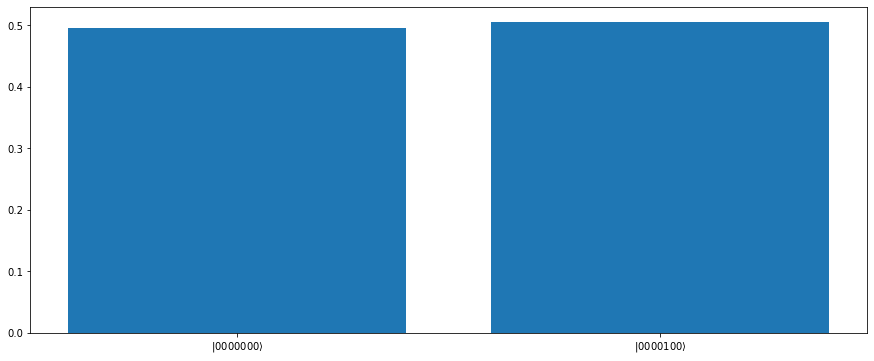

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

fname = 'TestGraphCircuit.txt'
circ = circuit(fname)
states = [('$|{0:0>' + str(int(circ.Nqubits)) + r'b}\rangle$').format(x) for x in range(2**circ.Nqubits)]
counts = np.zeros(2**circ.Nqubits)



for i in range(15000):
    circ = circuit(fname)
    circ.simulate_circuit()
    
    res = circ.measure_system()
    
    # This may be the wrong way? Could be that it has to be reversed
    counts[np.sum([res[i]*(2**i) for i in range(len(res))])] += 1


mask = np.argwhere(counts==0)
counts = np.delete(counts, mask)
states = np.delete(states, mask)
x = np.arange(len(states))        

plt.figure(figsize=(15, 6))
plt.bar(x, counts/np.sum(counts))
plt.xticks(x, states, fontsize=10)
plt.show()

#### Qiskit benchmark

In [83]:
qc = QuantumCircuit(circ.Nqubits)
for gate in circ.gates:
    if gate[0] == 'H':
        qc.h(gate[1])
    elif gate[0] == 'S':
        qc.s(gate[1])
    elif gate[0] == 'CZ':
            qc.cz(gate[1], gate[2])

qc.draw()

┌───┐        ┌───┐
q_0: ──────■─┤ H ├──────■─┤ H ├
           │ └───┘      │ └───┘
q_1: ──────┼───■────────┼──────
     ┌───┐ │   │  ┌───┐ │      
q_2: ┤ H ├─■───┼──┤ S ├─┼──────
     ├───┤     │  └───┘ │      
q_3: ┤ S ├─────■────────┼──────
     ├───┤   ┌───┐┌───┐ │      
q_4: ┤ S ├─■─┤ S ├┤ S ├─┼──────
     └───┘ │ └───┘└───┘ │      
q_5: ──────┼────────────┼──────
           │            │      
q_6: ──────■────────────■──────

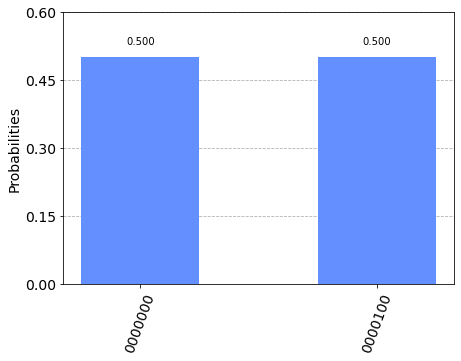

In [84]:
# Let's get the result:
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
result = svsim.run(qobj).result()

final_state = result.get_statevector()

plot_histogram(result.get_counts())